In [25]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from typing import List, Tuple
import warnings
from common_util import LogLinearArrhenius,LogLinearArrheniusModelFunc, setup_axis_default
import pickle
from scipy.optimize import bisect

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR

def get_arrhenius_process_params(ap: LogLinearArrhenius) -> np.ndarray:
    return ap.params[0],ap.params[1]

def get_model_ap_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return (*get_arrhenius_process_params(model.ap1),*get_arrhenius_process_params(model.ap2))

def get_model_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return *get_model_ap_params(model),model.n

class InvertedJMAK:

    def __init__(self,jmak_model: LogLinearArrheniusModelFunc):
        self.jmak_model = jmak_model
        self.ap1 = jmak_model.ap1
        self.ap2 = jmak_model.ap2
        self.n = jmak_model.n
    
    def get_time(self, X: np.ndarray,T: np.ndarray) -> np.ndarray:

        tinc = self.ap2(T)
        b = self.ap1(T)
        return 1.0/b*np.log(1./(1. - X))**(1/self.n) + tinc   

    def get_temperature(self, X: np.ndarray,
                              t: np.ndarray,
                              T_bounds: Tuple = (873.15,2273.15)) -> np.ndarray:
        
        def _search_function(T: float) -> float:
            return self.get_time(X,np.array([T])) - t

        return bisect(_search_function,*T_bounds)        
    

931.4
858.7
1115.2
1050.8


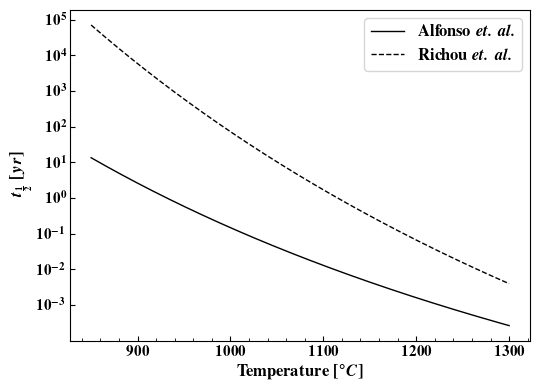

In [26]:

models = ['JMAK_alfonso_data_hr_robust weighted',
          'JMAK_richou_batch_a_robust weighted']

styles = ['-','--']
labels = [r'\textbf{Alfonso \textit{et. al.}}',r'\textbf{Richou \textit{et. al.}}']

fig,ax = plt.subplots(figsize = (5.5,4))
setup_axis_default(ax)
ax.set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)
ax.set_ylabel(r'\textbf{$t_{\frac{1}{2}}$ [$yr$]}',fontsize = 12)

T = np.linspace(850,1300,1000) + 273.15
for model_name,style,label in zip(models,styles,labels):
    
    with open(f'.model/{model_name}.pkl','rb') as f:
        jmak_model =pickle.load(f)
        ijmak_model = InvertedJMAK(jmak_model)
    
    for time in [1,10]:
        temp = ijmak_model.get_temperature(0.5,time*SECONDS_TO_YEAR)
        print(round(temp - 273.15,1))

    t = ijmak_model.get_time(0.5,T)

    ax.plot(T-273.15,t/SECONDS_TO_YEAR,color = 'k',lw = 1.0,ls = style,label = label)

ax.set_yscale('log')
ax.legend(fontsize = 12)

fig.tight_layout()
labels = np.logspace(-3,5,9)
ax.set_yticks(labels)
fig.savefig('.temp_images/half_time_vs_temp.svg')



### Comparison with Nogami Data

c:\Users\Michael\Documents\Git\modeling_tungsten\recrystallization\common_util.py:26: RuntimeWarning: invalid value encountered in power
  1.0 - np.exp(-b**n*(t - t_inc)**n)


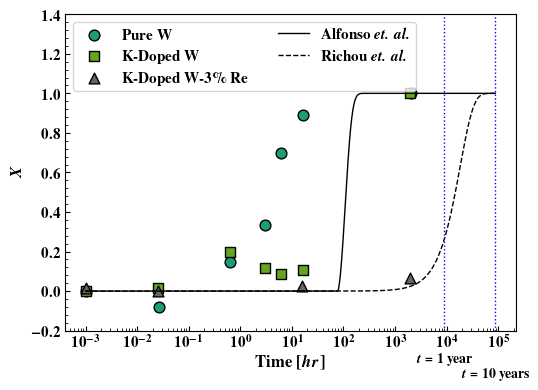

In [60]:
pure_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CPure W Data.csv',index_col = None)
k_doped_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CK-doped W Data.csv',index_col = None)
for df in [pure_w_df,k_doped_w_df]:
    df['X']  = 1 + (df['hardness'].min()  - df['hardness'])/(df['hardness'].iloc[0] - df['hardness'].min())

k_doped_re3_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CK-doped W-3Re Data.csv',index_col = None)
k_doped_re3_w_df['X'] = 1 - (k_doped_re3_w_df['hardness'] - 0.208*k_doped_re3_w_df['hardness'].max())/(k_doped_re3_w_df['hardness'].max() - k_doped_re3_w_df['hardness'].max()*0.208)
fig,ax = plt.subplots(figsize = (5.5,4))

setup_axis_default(ax)
ax.set_xlabel(r'\textbf{Time [$hr$]}',fontsize = 12)
ax.set_ylabel(r'$X$',fontsize = 12)

symbols = ['o','s','^']
colors = plt.get_cmap('Dark2')(np.linspace(0.1,0.9,len(symbols)))
labels = [r'Pure W',r'K-Doped W',r'K-Doped W-3\% Re'] 

min_t = float('inf')
max_t = -float('inf')
for df,color,symbol,label in zip([pure_w_df,k_doped_w_df,k_doped_re3_w_df],colors,symbols,labels):
    ax.scatter(df['time [hr]'],df['X'],facecolor = color,edgecolor = 'k',s = 60,
               marker = symbol,label = r'\textbf{' + label + r'}')
    min_t = min(min_t,df['time [hr]'].min())
    max_t = max(max_t,df['time [hr]'].max())


models = ['JMAK_alfonso_data_hr_robust weighted',
          'JMAK_richou_batch_a_robust weighted']

styles = ['-','--']
labels = [r'\textbf{Alfonso \textit{et. al.}}',r'\textbf{Richou \textit{et. al.}}']


time = np.linspace(min_t,HOURS_TO_YEAR*10,int(1e5))*SECONDS_TO_HOURS
temperature = np.ones_like(time)*1100.0 + 273.15

for model_name,style,label in zip(models,styles,labels):
    
    with open(f'.model/{model_name}.pkl','rb') as f:
        jmak_model =pickle.load(f)
    
    X = jmak_model.predict(np.array([time,temperature]).T)
    ax.plot(time/SECONDS_TO_HOURS,X,color = 'k',lw = 1.0,ls = style,label = label)

ax.axvline(HOURS_TO_YEAR*1,color = 'blue',lw = 1.0,ls = ':')
ax.axvline(HOURS_TO_YEAR*10,color = 'blue',lw = 1.0,ls = ':')

ax.text(HOURS_TO_YEAR*1, ax.get_ylim()[0] - 0.175, r'\textbf{$t$ = 1 year}', color='k', ha='center', va='top')
ax.text(HOURS_TO_YEAR*10, ax.get_ylim()[0] - 0.25, r'\textbf{$t$ = 10 years}', color='k', ha='center', va='top')


ax.set_xscale('log')
ax.set_ylim([-0.2,1.4])
ax.legend(fontsize = 11,ncols = 2,loc = 'upper left')
fig.tight_layout()
fig.savefig('.temp_images/nogami_rx_comp.svg')



